In [18]:
import pandas as pd
import numpy as np
import re
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams['figure.figsize'] = (12, 10)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

filepath = u"./data/bio_format_resume1.tsv"
#filepath = u"./resume_sentence_dataset.csv"



#filepath = u"./data/resume_sentence_dataset_balanced.csv"

data = pd.read_csv(filepath,sep="\t")
data = data.dropna()
data

,Word,Tag
0,Govardhana,Name
1,K,Name
2,Senior,Profil
3,Software,Profil
4,Engineer,Profil
...,...,...
75767,Arc,O
75768,"sight,",O
75769,HP,O
75770,Service,O


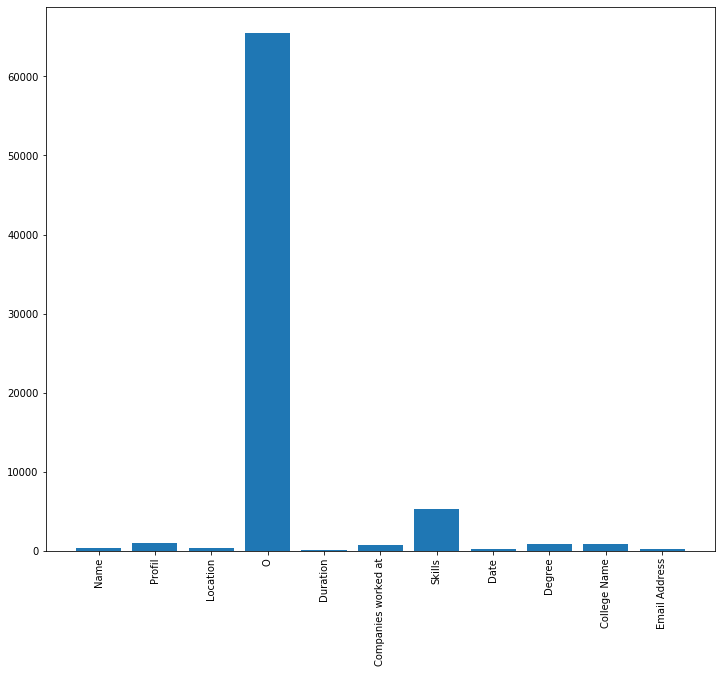

In [9]:
## remove all parenthesis 
#data["Word"] = data["Word"].apply(lambda x :  re.sub(r'[()]*',r'', x))
#data.loc[data.index[data.Word.str.contains("[0-9]{4}$")],'Tag'] = "Year"
data["Tag"].value_counts()

from collections import Counter

occ = Counter(data["Tag"])
occ

plt.xticks(rotation="vertical")
plt.bar(occ.keys(), occ.values())
plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [339]:
#remove special characters
#data["Word"] = data["Word"].apply(lambda x: re.sub(r'[^\x00-\x7f]',r'', x) )
import math

words = list(set(data["Word"].values))
n_words = len(words)  

# group word by sentence
sentence_columns = []
sentence_number = math.floor(len(data)/25)
remaining = len(data) - sentence_number * 25

for i in range(sentence_number):
    for j in range(25):
        sentence_columns.append(i)
for i in range(remaining):
    sentence_columns.append(sentence_number+1)
    

data['Sentence #'] = sentence_columns
data =  data[["Sentence #","Word","Tag"]]
data

,Sentence #,Word,Tag
0,0,Govardhana,Name
1,0,K,Name
2,0,Senior,Profil
3,0,Software,Profil
4,0,Engineer,Profil
...,...,...,...
75767,3018,Arc,O
75768,3018,"sight,",O
75769,3018,HP,O
75770,3018,Service,O


In [3]:
## remove random O-Tag
import random
import math

index = data.index[data['Tag'] == "O"]
O_tagSize = math.ceil((len(index)*0.6))

#drop_indices = np.random.choice(index, O_tagSize, replace=False)
#data = data.drop(drop_indices)
print(len(data))
data["Tag"].value_counts()



720764


O                      65524
Duration               65524
Name                   65524
Date                   65524
Companies worked at    65524
Location               65524
Degree                 65524
Skills                 65524
College Name           65524
Profil                 65524
Email Address          65524
Name: Tag, dtype: int64

In [4]:
len(data["Word"])

720764

In [5]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)

In [6]:
sent = getter.get_next()
print(sent)
sentences = getter.sentences


[('2', 'Duration'), ('Month', 'Duration'), ('Core', 'Profil'), ('Java', 'Profil'), ('Developer', 'Profil'), ('Languages', 'O'), ('Java,', 'Skills'), ('Go', 'Skills'), ('Lang', 'Skills'), ('Oracle', 'Skills'), ('PL-SQL', 'Skills'), ('programming,', 'O'), ('Sales', 'Profil'), ('Force', 'Profil'), ('Developer', 'Profil'), ('with', 'O'), ('APEX.', 'Skills'), ('Profils', 'O'), ('&', 'O'), ('Promotions', 'O'), ('Willing', 'O'), ('to', 'O'), ('relocate:', 'O'), ('Anywhere', 'O'), ('WORK', 'O')]


In [7]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, label in sent]

def sent2tokens(sent):
    return [token for token, label in sent]

In [8]:
X = [sent2features(s) for s in sentences]


y = [sent2labels(s) for s in sentences]

In [11]:
from sklearn.model_selection import train_test_split

train_docs, test_docs, train_labels, test_labels = train_test_split(X, y)

len(train_docs), len(test_docs)


(21623, 7208)

In [13]:
from sklearn_crfsuite import CRF
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)

crf.fit(train_docs, train_labels)

C:\Users\Cheikh\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [15]:
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

labels = list(crf.classes_)

labels

y_pred = crf.predict(test_docs)
print(metrics.flat_f1_score(test_labels, y_pred,average='weighted', labels=labels))

sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

print(metrics.flat_classification_report(test_labels, y_pred, digits=3))

0.9836293233825176
                     precision    recall  f1-score   support

       College Name      0.991     0.993     0.992     16003
Companies worked at      0.996     0.991     0.994     16179
               Date      0.998     0.998     0.998     16011
             Degree      0.996     0.996     0.996     16501
           Duration      0.997     0.999     0.998     16741
      Email Address      0.961     0.975     0.968     16962
           Location      0.998     0.996     0.997     15984
               Name      0.970     0.966     0.968     16875
                  O      0.957     0.935     0.946     16510
             Profil      0.991     0.994     0.992     16561
             Skills      0.966     0.980     0.973     15862

           accuracy                          0.984    180189
          macro avg      0.984     0.984     0.984    180189
       weighted avg      0.984     0.984     0.984    180189



In [244]:
import eli5
eli5.show_weights(crf, top=30)

C:\Users\Cheikh\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


From \ To,College Name,Companies worked at,Date,Degree,Duration,Email Address,Location,Name,O,Profil,Skills
College Name,4.255,0.0,1.398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Companies worked at,0.0,2.68,0.0,0.0,0.0,0.0,0.811,0.0,1.1,0.0,-0.107
Date,0.0,0.0,0.0,0.214,0.0,0.0,0.0,0.0,0.143,0.0,0.0
Degree,3.449,0.0,0.0,3.96,0.0,0.0,0.0,0.0,-0.233,0.0,0.0
Duration,0.0,0.0,0.0,0.0,3.013,0.0,0.0,0.0,0.0,0.0,0.0
Email Address,0.0,0.0,0.0,0.0,0.0,2.958,0.0,0.0,0.633,0.0,0.0
Location,0.0,0.0,0.0,0.0,0.0,1.57,0.079,0.0,0.987,0.0,0.0
Name,0.0,0.0,0.0,0.0,0.0,0.0,1.146,3.215,-0.405,2.098,0.0
O,-0.177,0.566,0.027,0.0,0.0,1.043,-0.12,0.0,2.435,0.192,0.0
Profil,0.0,2.446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.456,0.0


In [243]:
crf = CRF(algorithm='lbfgs',
          c1=10,
          c2=0.1,
          max_iterations=100,
          all_possible_transitions=False)


crf.fit(train_docs, train_labels)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=False,
    averaging=None, c=None, c1=10, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [ ]:
y_pred = crf.predict(test_docs)
metrics.flat_f1_score(test_labels, y_pred,
                      average='weighted', labels=labels)

In [ ]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    test_labels, y_pred, labels=sorted_labels, digits=3
))

In [ ]:
import eli5
eli5.show_weights(crf, top=30)